In [1]:
import sys
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
#needed for import
sys.path.append(os.path.abspath('..'))

In [3]:
#helper functions needed for evaluation
from src.models.helper import evaluate_model, prep_data, clean_column_names

In [4]:
#loading datasets
train_set = pd.read_csv('../data/train_set.csv')
test_set = pd.read_csv('../data/test_set.csv')

In [5]:
#preparing data
X_train, Y_train, X_test, Y_test = prep_data(train_set, test_set)

In [6]:
#evaluating linear regression
model = joblib.load('../models/linear_reg.joblib')
Y_hat = model.predict(X_test)
evaluate_model('Linear Regression', Y_test, Y_hat)


Linear Regression Model Statstics
MAE Score = 19.71
RMSE Score = 30.07
MSE Score = 904.23
MAPE Score = 0.37



In [7]:
#evaluating svr 
model = joblib.load('../models/svr.joblib')
Y_hat = model.predict(X_test)
evaluate_model('SVR', Y_test, Y_hat)


SVR Model Statstics
MAE Score = 18.38
RMSE Score = 30.04
MSE Score = 902.69
MAPE Score = 0.38



In [8]:
#evaluating elastic net
model = joblib.load('../models/elastic_net.joblib')
Y_hat = model.predict(X_test)
evaluate_model('Elastic Net', Y_test, Y_hat)


Elastic Net Model Statstics
MAE Score = 19.41
RMSE Score = 29.67
MSE Score = 880.42
MAPE Score = 0.36



In [9]:
#evaluating xgboost
model = joblib.load('../models/xgb.joblib')
Y_hat = model.predict(X_test)
evaluate_model('XG Boost', Y_test, Y_hat)


XG Boost Model Statstics
MAE Score = 16.33
RMSE Score = 26.40
MSE Score = 697.13
MAPE Score = 0.22



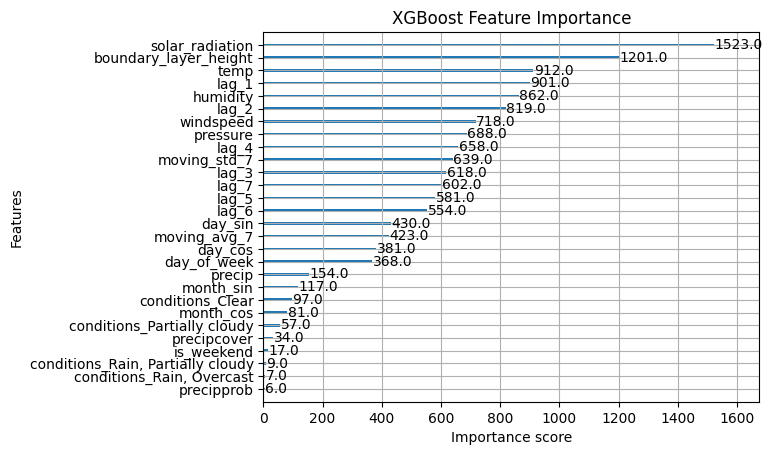

In [10]:
#checking the feature importance of the xgb model
xgb.plot_importance(model)
plt.title("XGBoost Feature Importance")
plt.show()

In [11]:
#evaluating catboost
model = joblib.load('../models/cat.joblib')
Y_hat = model.predict(X_test)
evaluate_model('Cat Boost', Y_test, Y_hat)


Cat Boost Model Statstics
MAE Score = 15.95
RMSE Score = 25.73
MSE Score = 662.13
MAPE Score = 0.22



CatBoost Top 10 Features:
                  Feature  Importance
11                  lag_1   22.565584
7               windspeed    6.969903
2                    temp    5.465975
1   boundary_layer_height    5.325727
12                  lag_2    4.911182
3                humidity    4.714083
23                day_sin    4.535470
0         solar_radiation    4.512940
16                  lag_6    4.091649
14                  lag_4    3.906303


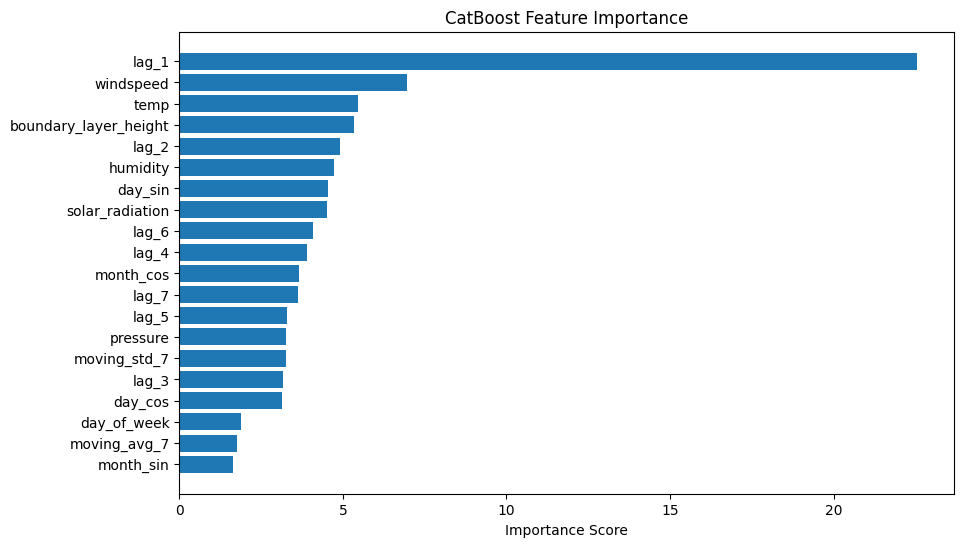

In [12]:
#checking the feature importance of the catboost model
cat_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("CatBoost Top 10 Features:")
print(cat_importance.head(10))

#plotting
plt.figure(figsize=(10, 6))
plt.barh(cat_importance['Feature'][:20], cat_importance['Importance'][:20])
plt.gca().invert_yaxis() # Highest importance at top
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.show()

In [16]:
#evaluating lgbm
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

model = joblib.load('../models/lgbm.joblib')
Y_hat = model.predict(X_test)
evaluate_model('LGBM', Y_test, Y_hat)


LGBM Model Statstics
MAE Score = 17.53
RMSE Score = 28.68
MSE Score = 822.32
MAPE Score = 0.23



In [18]:
#let us try a hybrid approach

#loading the two best models
xgb_model = joblib.load("../models/xgb.joblib") 
cat_model = joblib.load("../models/cat.joblib")

#getting their predictions
pred_xgb = xgb_model.predict(X_test)
pred_cat = cat_model.predict(X_test)

#this voting split gives the best results
ensemble_pred = (0.72 * pred_cat) + (0.28 * pred_xgb)

#evaluating the new hybrid model
evaluate_model('Ensemble (Hybrid)', Y_test, ensemble_pred)


Ensemble (Hybrid) Model Statstics
MAE Score = 15.71
RMSE Score = 25.33
MSE Score = 641.82
MAPE Score = 0.21



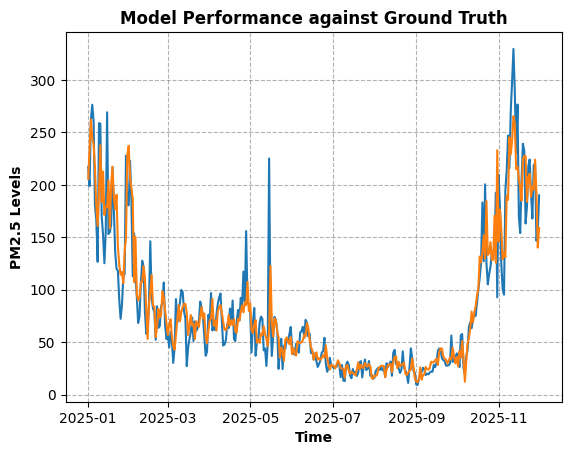

In [16]:
#let us try to visualize our model's results
test_set['datetime'] = pd.to_datetime(test_set['datetime'])

#plot set up
plt.title('Model Performance against Ground Truth', weight = 'bold')
plt.xlabel('Time', weight = 'bold')
plt.ylabel('PM2.5 Levels', weight = 'bold')
plt.grid(alpha = 0.3, linestyle = '--', color = 'black')

#ground truth plot
plt.plot(test_set['datetime'], Y_test)
#model prediction plot
plt.plot(test_set['datetime'], ensemble_pred)

plt.show()

##**Comments**

From this plot, it is evident that our model has captured most of the data well however,  unfortunatley, it struggles to model really high and low peaks and troughs i.e. extreme sudden changes in PM2.5 levels. This is in accordance with our MAE and RMSE Scores, as our RMSE is a little higher (which penalizes larger errors) than our MAE.

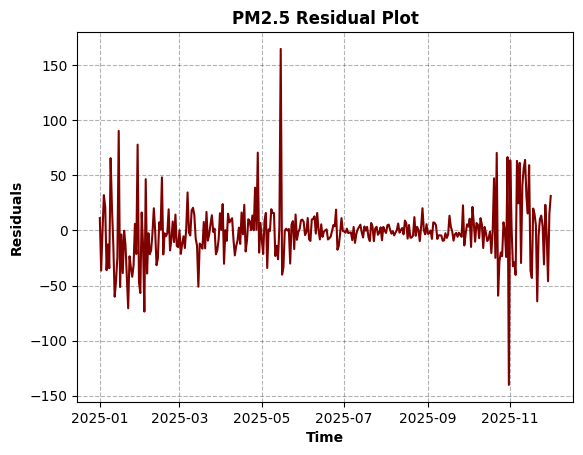

In [22]:
#let us plot the residuals and see if there is some correlation between them

#calculating the residuals
residuals = Y_test - ensemble_pred

#residual plot
plt.plot(test_set['datetime'], residuals, color = 'maroon')
plt.xlabel('Time', weight = 'bold')
plt.ylabel('Residuals', weight = 'bold')
plt.title('PM2.5 Residual Plot', weight = 'bold')
plt.grid(alpha = 0.3, linestyle = '--', color = 'black')

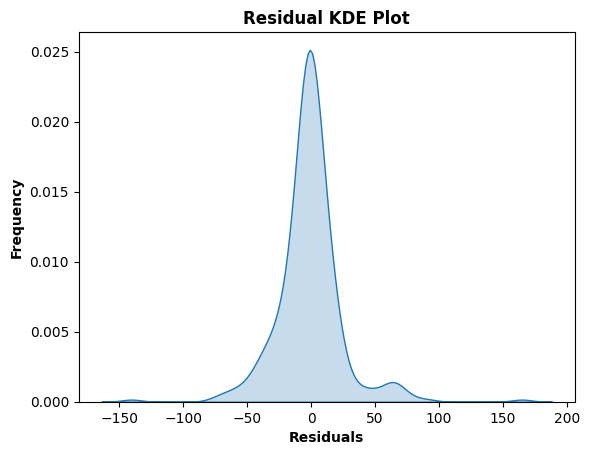

In [26]:
#let us try to check if the residuals follow a normal distribution
import seaborn as sns

sns.kdeplot(data = residuals, fill = True) 
plt.xlabel('Residuals', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Residual KDE Plot', weight = 'bold')
plt.show()

##**Comments**

Most of the time, our model is very close to the correct value. The fact that the peak is so high and narrow means that for the easy days (likely summer/monsoon), our model is precise. It is not systematically over-predicting or under-predicting. However, our model is bipolar. It is usually very accurate (the tall peak), but when it fails, it fails catastrophically (the distant bars). It lacks the middle ground errors that a normal distribution has.

##**Final Summary**

Our model is statistically sound and unbiased, meaning it generally understands the normal behavior of air quality very well. It captures the seasonal trends (the rise and fall of pollution over the year) almost perfectly.

However, it struggles with extreme volatility. It is a conservative model. It plays it safe by predicting the average trend but fails to catch sudden, massive spikes in pollution (outliers), which creates periods of high error.